In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pint
import plotly.express as px
import plotly.graph_objects as go
import xarray as xr
from dask.distributed import Client
from pint import UnitStrippedWarning
from seapopym.configuration.no_transport.parameter import ForcingParameters
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.standard.units import StandardUnitsLabels

from seapopym_optimization import Observation, constraint, wrapper
from seapopym_optimization.cost_function import NoTransportCostFunction
from seapopym_optimization.functional_groups import FunctionalGroupOptimizeNoTransport, Parameter
from seapopym_optimization.genetic_algorithm import GeneticAlgorithm, GeneticAlgorithmParameters
from seapopym_optimization.taylor_diagram import ModTaylorDiagram, generate_mod_taylor_diagram

warnings.simplefilter("ignore", category=UnitStrippedWarning)
xr.set_options(
    display_expand_attrs=False,
    display_expand_data_vars=False,
    display_expand_coords=False,
    display_expand_data=False,
)

In [2]:
path_to_forcing = "../../../1_data_processing/1_1_Forcing/1_optional_extract_barents_sea/Barents_sea_forcing.zarr"
path_to_obs = "../../../1_data_processing/1_1_Forcing/1_optional_extract_barents_sea/zoo_1987_1999.zarr"
export_file_name = "SeapoPym_BARENTS_1999_climato_vgpm_opti_all_parameters_1_group"

In [60]:
LATITUDE = 72
LONGITUDE = 20
TIME_START = "1998-01-01"
TIME_END = "1999-12-01"
STABILIZATION_TIME = 5
SAVE = True

## Loading


### Forcing


In [4]:
forcing = xr.open_zarr(path_to_forcing)
forcing = forcing.sel(time=slice(TIME_START, TIME_END))
forcing["T"].attrs["units"] = StandardUnitsLabels.temperature.units
forcing.load()

<xarray.Dataset> Size: 34kB
Dimensions:              (depth: 1, latitude: 1, longitude: 1, time: 700)
Coordinates: (4)
Data variables: (5)
Attributes: (6)

### Epipelagic layer


In [5]:
epi_layer_depth = forcing["pelagic_layer_depth"].load()
epi_layer_depth = epi_layer_depth.resample(time="1D").mean()
epi_layer_depth.attrs["units"] = "meter"
epi_layer_depth = epi_layer_depth.pint.quantify()
epi_layer_depth

<xarray.DataArray 'pelagic_layer_depth' (latitude: 1, longitude: 1, time: 700)> Size: 6kB
[m] 300.7 301.5 302.4 303.4 304.4 305.1 ... 265.0 266.6 268.1 269.6 271.3 273.0
Coordinates: (3)
Attributes: (1)

<!-- ## Observed NPP -->


### Observations


In [6]:
with xr.set_options(keep_attrs=True):
    observations = xr.open_zarr(path_to_obs).load()
    # observations = observations.sel(latitude=LATITUDE, longitude=LONGITUDE, method="nearest")
    observations = observations.resample(time="1D").mean().dropna("time")
    observations = observations.pint.quantify().pint.to("mg/m^2").pint.dequantify()
    observations = (
        observations.mean("latitude")
        .expand_dims({"latitude": [LATITUDE]})
        .transpose("time", "latitude", "longitude", "layer")
    )
    observations.latitude.attrs = forcing.latitude.attrs
    # observations = observations * epi_layer_depth
    # observations = observations.drop_vars("depth")
observations

<xarray.Dataset> Size: 3kB
Dimensions:    (latitude: 1, time: 156, longitude: 1, layer: 1)
Coordinates: (4)
Data variables: (1)

Remove the X first months to let the model reach the stationary state.


In [7]:
observations_selected = observations.sel(time=slice(TIME_START, TIME_END))
observations_selected_without_init = observations_selected.isel(time=slice(STABILIZATION_TIME, None))
observations_selected_without_init

<xarray.Dataset> Size: 328B
Dimensions:    (latitude: 1, time: 19, longitude: 1, layer: 1)
Coordinates: (4)
Data variables: (1)

Create structure for SeapoPym simulation.


In [8]:
forcing_parameters = ForcingParameters(
    temperature=ForcingUnit(forcing=forcing["T"], resolution=1 / 12, timestep=1),
    primary_production=ForcingUnit(forcing=forcing["npp"], resolution=1 / 12, timestep=1),
)

2025-01-28 10:59:30,366 :: Seapodym ::  WARNING ::
|	npp unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



## Setup the parameters and the cost function


In [9]:
functional_groups = [
    FunctionalGroupOptimizeNoTransport(
        name="TOTAL",
        day_layer=0,
        night_layer=0,
        energy_coefficient=Parameter("TOTAL_energy_coefficient", 0.001, 0.4),
        tr_rate=Parameter("TOTAL_tr_rate", -0.3, -0.001),
        tr_max=Parameter("TOTAL_tr_max", 0, 50),
        inv_lambda_rate=Parameter("TOTAL_inv_lambda_rate", -0.3, -0.001),
        inv_lambda_max=Parameter("TOTAL_inv_lambda_max", 0, 500),
    ),
]
# [1, 1, 0.1668, 10.38, -0.11, 150, 0.15]

In [10]:
cost_function = NoTransportCostFunction(
    functional_groups=functional_groups,
    forcing_parameters=forcing_parameters,
    observations=[Observation(observations_selected_without_init)],
)

Set the genetic algorithm meta parameters.


In [11]:
genetic_algo_parameters = GeneticAlgorithmParameters(
    MUTPB=0.1,
    INDPB=0.2,
    ETA=5,
    CXPB=0.8,
    NGEN=10,
    POP_SIZE=500,
    cost_function_weight=(-1,),
)

Finaly, create the Genetic Algorithm.


In [12]:
client = Client()
genetic_algo = GeneticAlgorithm(
    cost_function=cost_function,
    parameter_genetic_algorithm=genetic_algo_parameters,
    client=client,
)

And watch the magic on the Dask dashboard :


In [13]:
genetic_algo.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50283,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:50297,Total threads: 3
Dashboard: http://127.0.0.1:50298/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:50286,


## Run the optimization


In [14]:
viewer = genetic_algo.optimize()

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,18.735781,36.483352,0.266611,314.837757,500,0.000
1,6.126266,13.311831,0.266611,122.708528,500,0.236
2,3.705038,10.554089,0.275172,142.684537,500,0.206
3,2.518566,5.804483,0.251349,66.353501,500,0.130
4,1.710165,3.829086,0.265916,50.289293,500,0.164
5,1.084053,2.031814,0.253440,20.555535,500,0.156
6,0.875833,1.391958,0.250057,14.975792,500,0.140
7,0.693812,1.235037,0.250057,12.424196,500,0.196
8,0.540483,1.157102,0.250910,22.984731,500,0.198


Generations: 100%|██████████| 10/10 [05:39<00:00, 33.93s/it]


## Optimization statistics


In [15]:
viewer.hall_of_fame

TOTAL_energy_coefficient  TOTAL_tr_max  TOTAL_tr_rate  \
generation individual                                                          
7          318                         0.310737      4.791852      -0.228580   
6          190                         0.310737      4.791852      -0.228580   
9          182                         0.300415      2.818705      -0.158257   
6          404                         0.300415      1.305421      -0.232301   
9          79                          0.300415      1.305421      -0.283599   
...                                         ...           ...            ...   
0          60                          0.363300     29.206908      -0.140121   
           0                           0.316446      9.146945      -0.230055   
           327                         0.354074      2.877406      -0.040460   
           21                          0.359728     18.044806      -0.254137   
           495                         0.388696     41.155382      -0.166059   

                       TOTAL_inv_lambda_max  TOTAL_inv_lambda_rate     fitness  
generation individual                                                           
7          318                   190.960082              -0.281802    0.250057  
6          190                   190.960082              -0.281802    0.250057  
9          182                   195.457812              -0.281563    0.250482  
6          404                   195.457812              -0.279969    0.250910  
9          79                    195.457812              -0.279969    0.250910  
...                                     ...                    ...         ...  
0          60                    416.592397              -0.044591  181.506231  
           0                     458.229779              -0.007967  189.354695  
           327                   423.222323              -0.003899  231.419915  
           21                    471.707295              -0.011565  254.032078  
           495                   480.574252              -0.001815  314.837757  

[4193 rows x 6 columns]

In [16]:
viewer.fitness_evolution()

In [17]:
viewer.box_plot(3, nbest=1000)

In [61]:
fig = viewer.parallel_coordinates(1000, unselected_opacity=0)
fig

In [62]:
if SAVE:
    fig.write_html(f"Parallel_coordinates_{export_file_name}.html")

# Prepare results for ploting


## Run simulation with original parameters


In [63]:
original_config = [[0, 0, 0.1668, 10.38, -0.11, 150, -0.15]]
print(f"Original configuration: {list(original_config[0])}")

Original configuration: [0, 0, 0.1668, 10.38, -0.11, 150, -0.15]


In [64]:
original_model = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=original_config, groups_name=["Total"]),
)

original_model.run()

## Run simulation with optimized parameters


In [65]:
best_individual = cost_function.functional_groups.generate_matrix(viewer.hall_of_fame.iloc[0])
print(f"Best individual: {list(best_individual[0])}")

Best individual: [0.0, 0.0, 0.3107373595825442, 4.791852099228045, -0.22858003682586972, 190.96008246026736, -0.28180226486796167]


In [66]:
best_model = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=best_individual, groups_name=["Total"]),
)

best_model.run()

And with the X best individuals :


In [67]:
NB_INDIVIDUAL_TO_SHOW = 10

min_biomass_D1N1 = best_model.export_biomass().sel(functional_group=0).data.flatten()
max_biomass_D1N1 = best_model.export_biomass().sel(functional_group=0).data.flatten()


biomass_accumulated = []

for cpt in range(0, NB_INDIVIDUAL_TO_SHOW):
    individual = cost_function.functional_groups.generate_matrix(viewer.hall_of_fame.iloc[cpt])
    model = wrapper.model_generator_no_transport(
        forcing_parameters=forcing_parameters,
        fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=individual, groups_name=["Total"]),
    )
    model.run()

    biomass_accumulated.append(model.export_biomass().expand_dims({"individual": [cpt]}))

In [68]:
with xr.set_options(keep_attrs=True):
    best_individuals_simulations = xr.concat(biomass_accumulated, dim="individual")
    min_biomass_D1N1 = (
        best_individuals_simulations.sel(functional_group=0).min("individual").isel(latitude=0, longitude=0)
    )
    max_biomass_D1N1 = (
        best_individuals_simulations.sel(functional_group=0).max("individual").isel(latitude=0, longitude=0)
    )

### Format the results


Convert to pandas series.


In [69]:
optimized_biomass_pandas = (
    best_model.export_biomass()
    .pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .to_dataframe()
    .pivot_table(index="time", columns="functional_group", values="biomass")
)
original_biomass_pandas = (
    original_model.export_biomass()
    .pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .to_dataframe()
    .pivot_table(index="time", columns="functional_group", values="biomass")
)

observations_night_pandas = (
    observations_selected_without_init.pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .night.dropna("time")
    .to_dataframe()
    .reset_index()
    .set_index("time")["night"]
)
layer_pandas = epi_layer_depth.pint.dequantify().to_dataframe().reset_index().set_index("time")["pelagic_layer_depth"]

Then resample to month.


In [70]:
monthly_obs_night = observations_night_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_night.index = monthly_obs_night.index.to_period("M").to_timestamp()

monthly_pred_d1n1 = optimized_biomass_pandas.iloc[:, 0].resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred_d1n1.index = monthly_pred_d1n1.index.to_period("M").to_timestamp()


monthly_pred_orignal = original_biomass_pandas.iloc[:, 0].resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred_orignal.index = monthly_pred_orignal.index.to_period("M").to_timestamp()

monthly_layer = layer_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_layer.index = monthly_layer.index.to_period("M").to_timestamp()

# Plot


### Correlation matrix of X best individuals


In [71]:
NB_INDIVIDUAL_CORRELATION = 100

indiv_param = viewer.hall_of_fame.iloc[:NB_INDIVIDUAL_CORRELATION, :-1].to_numpy()
param_names = viewer.hall_of_fame.columns[:-1]

corr_matrix = np.corrcoef(indiv_param.T)
np.fill_diagonal(corr_matrix, np.nan)

fig = px.imshow(
    corr_matrix,
    text_auto=False,
    aspect="auto",
    color_continuous_scale=[[0, "blue"], [0.5, "white"], [1, "red"]],
    zmin=-1,
    zmax=1,
    x=param_names,
    y=param_names,
)
fig.update_layout(
    title="Correlation Matrix of Hall of Fame Parameters (Lower Triangle)",
    plot_bgcolor="rgba(0,0,0,0)",
    paper_bgcolor="rgba(0,0,0,0)",
    xaxis={"showgrid": False, "tickangle": -35},
    yaxis={"showgrid": False},
)

fig.show()

In [72]:
if SAVE:
    fig.write_html(f"Correlation_best_individuals_{export_file_name}.html")

### Daily with best individuals


In [73]:
x = best_model.export_biomass().time.to_series()
x_rev = pd.concat([x, x[::-1]])

fig = go.Figure()

# D1N1 data
y_D1N1 = (
    best_model.export_biomass()
    .sel(functional_group=0)
    .pint.quantify()
    .pint.to("mg/m2")
    .pint.dequantify()
    .data.flatten()
)
y_D1N1_upper = max_biomass_D1N1.pint.quantify().pint.to("milligram / meter ** 2")
y_D1N1_lower = min_biomass_D1N1.pint.quantify().pint.to("milligram / meter ** 2")[::-1]
y_D1N1_rev = np.concatenate([y_D1N1_upper, y_D1N1_lower])

fig = go.Figure()

# D1N1 traces
fig.add_trace(
    go.Scatter(
        x=x_rev,
        y=y_D1N1_rev,
        fill="toself",
        fillcolor="rgba(255,0,0,0.2)",
        line_color="rgba(255,255,255,0)",
        name=f"D1N1 : {NB_INDIVIDUAL_TO_SHOW} best individuals",
    )
)

fig.add_trace(
    go.Scatter(
        x=x,
        y=y_D1N1,
        line_color="rgb(255,0,0)",
        name="D1N1 : Best individual",
    )
)

# OBSERVATIONS ------------------------------------------------ #


fig.add_trace(
    go.Scatter(
        x=observations_selected_without_init.night.time.data.flatten(),
        y=observations_selected_without_init.night.pint.quantify().pint.to("mg/m2").pint.dequantify().data.flatten(),
        mode="lines+markers",
        name="Night observations",
        line={"dash": "dash", "color": "royalblue", "width": 1},
    )
)

# PRIMARY PRODUCTION ----------------------------------------- #

fig.add_trace(
    go.Scatter(
        x=best_model.state.primary_production.time.data.flatten(),
        y=best_model.state.primary_production.pint.quantify().pint.to("mg/m2/day").pint.dequantify().data.flatten(),
        mode="lines",
        name="Primary Production (mg/m2/day)",
        line={"dash": "dot", "color": "green", "width": 1},
    )
)

fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Biomass (mg/m2)",
    title=f"Biomass over Time (Daily) : {export_file_name}",
    showlegend=True,
)

fig.show()

In [74]:
if SAVE:
    fig.write_html(f"Biomass_best_individuals_{export_file_name}.html")

### Monthly with original parameters


In [75]:
fig = go.Figure(
    layout={
        "title": "SeapoPym Monthly Biomass during day (CAFE npp) and Observations : HOT station + all param. optimization + 2 groups",
        "xaxis": {"title": "Time"},
        "yaxis": {"title": "Biomass . Epipelagic layer depth (mg/m^2)"},
    }
)

# Night ------------------------------------------------ #
fig.add_trace(
    go.Scatter(
        x=monthly_pred_d1n1.index,
        y=monthly_pred_d1n1,
        mode="lines",
        line={"color": "rgb(0,176,246)"},
        name="Predictions Night",
    )
)
fig.add_trace(
    go.Scatter(
        x=monthly_obs_night.index,
        y=monthly_obs_night,
        # fill="tonextx",
        # fillcolor="rgba(0,176,246,0.15)",
        mode="lines+markers",
        line={"color": "royalblue", "dash": "dash", "width": 1},
        name="Observations (night)",
    )
)

# LMTL ------------------------------------------------ #
fig.add_trace(
    go.Scatter(
        x=monthly_pred_orignal.index,
        y=monthly_pred_orignal,
        mode="lines",
        line={"color": "grey"},
        name="Predictions Original",
    )
)


# LAYER ------------------------------------------------ #

fig.add_trace(px.line(monthly_layer).data[0])

fig.update_traces(
    yaxis="y2",
    selector={"name": "pelagic_layer_depth"},
    line={"color": "green", "width": 1, "dash": "dot"},
)
fig.update_layout(
    yaxis2={"title": "Layer Depth (m)", "overlaying": "y", "side": "right"},
    height=600,
)
fig.update_layout(legend={"y": 1.0, "x": 1.1})
fig.show()

In [76]:
if SAVE:
    fig.write_html(f"Biomass_monthly_with_original_{export_file_name}.html")

### Taylor Diagram


correlation [0.944739484153357, 0.899390338943277]
norm STD [1.0645337823745327, 0.7553458742945655]
bias [-0.1638995410048164, -0.2974138057479074]
NRMSE [0.3490243271864477, 0.4602671246259409]
name ['Barents Sea - Optimized', 'Barents Sea - Original']


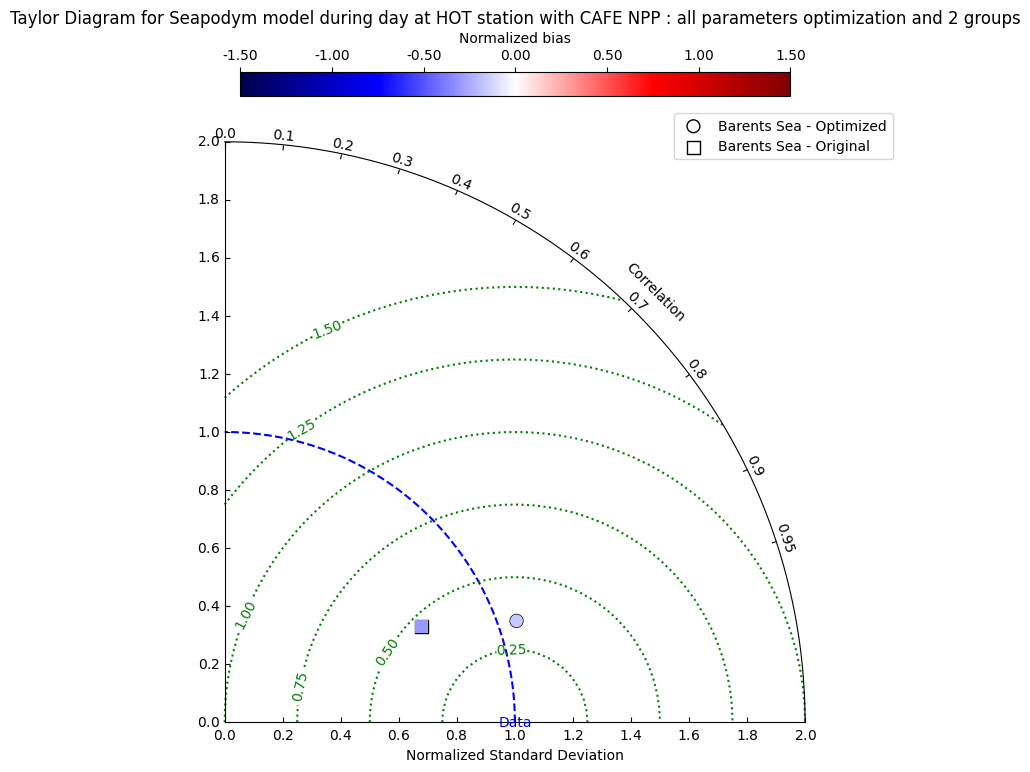

In [77]:
diagram = ModTaylorDiagram()

all_model = [monthly_pred_d1n1, monthly_pred_orignal]
all_obs = [monthly_obs_night, monthly_obs_night]

all_names = ["Barents Sea - Optimized", "Barents Sea - Original"]

for model, obs, name in zip(all_model, all_obs, all_names):
    diagram = generate_mod_taylor_diagram(diagram, obs=obs, model=model[obs.index], name=name)
diagram.plot()
plt.title(
    "Taylor Diagram for Seapodym model during day at HOT station with CAFE NPP : all parameters optimization and 2 groups"
)

# export the figure
if SAVE:
    plt.savefig(f"Taylor_{export_file_name}.png")

plt.show()

In [78]:
if SAVE:
    diagram.get_stats().to_csv(f"Stats_{export_file_name}.csv", index=False)
diagram.get_stats()

,name,correlation_coefficient,normalized_standard_deviation,bias,normalized_root_mean_square_deviation
0,Barents Sea - Optimized,0.944739,1.064534,-0.163900,0.349024
1,Barents Sea - Original,0.899390,0.755346,-0.297414,0.460267


### Telagrand diagram


In [79]:
# Quantify and convert observations to mg/m2
obs = (
    observations_selected_without_init.night.isel(latitude=0, longitude=0, layer=0)
    .pint.quantify()
    .pint.to("mg/m2")
    .pint.dequantify()
    # .resample(time="1D")
    # .interpolate("linear")
)

# Select and convert predictions to mg/m2
pred = (
    best_individuals_simulations.isel(latitude=0, longitude=0, functional_group=0)
    .sel(time=obs.time)
    .pint.quantify()
    .pint.to("mg/m2")
    .pint.dequantify()
)

# Calculate ranks for observations
all_ranks = []
for time_ite in obs.time:
    pred_ite = np.sort(pred.sel(time=time_ite).data)
    obs_ite = float(obs.sel(time=time_ite))
    rank = np.searchsorted(pred_ite, obs_ite)
    all_ranks.append(rank)

In [80]:
fig = go.Figure()


value, count = np.unique(all_ranks, return_counts=True)
count = count / count.sum()
fig.add_trace(
    go.Bar(
        x=value,
        y=count,
        name="Ranks",
        marker_color="firebrick",
        opacity=0.75,
    )
)

# Update layout
fig.update_layout(
    title="Telagrand Diagram",
    xaxis_title="Rank",
    yaxis_title="P(Rank)",
    barmode="group",
)

fig.show()

In [81]:
if SAVE:
    fig.write_html(f"Telagrand_diagram_{export_file_name}.html")